In [133]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy

import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec
import geopandas
import cartopy.io.shapereader as shpreader
import shapely

from matplotlib.patches import Rectangle


In [49]:
places = pd.read_csv('../data/place_df.csv')

In [79]:
pdf = pd.read_csv(f'../data/gridcell_studies_6 - Precipitation - upper_pred_2.5.csv').rename(columns={
    "da_cat": "precip_da_cat",
    "n_study_prop": "precip_study_prop"
})
tdf = pd.read_csv(f'../data/gridcell_studies_6 - Temperature - upper_pred_2.5.csv').rename(columns={
    "da_cat": "temp_da_cat",
    "n_study_prop": "temp_study_prop"
})
print(tdf.shape)

df = (pdf[["LAT","LON","precip_da_cat","precip_study_prop"]]
      .merge(tdf[["LAT","LON","temp_da_cat","temp_study_prop"]])
     ).fillna(0)

df['precip_da_cat'] = abs(df['precip_da_cat'])
df['temp_da_cat'] = abs(df['temp_da_cat'])

df['temp_da_binary'] = np.where(df['temp_da_cat']>1,1,0)
df['precip_da_binary'] = np.where(df['precip_da_cat']>1,1,0)

df["n_da_impacts"] = df[['temp_da_binary','precip_da_binary']].sum(axis=1)

df["max_da_cat"] = np.max(df[['precip_da_cat','temp_da_cat']],axis=1)
print(df.shape)
df.head()

(10368, 8)
(10368, 10)


,LAT,LON,precip_da_cat,precip_study_prop,temp_da_cat,temp_study_prop,temp_da_binary,precip_da_binary,n_da_impacts,max_da_cat
0,-88.75,181.25,0.0,0.0,0.0,0.0,0,0,0,0.0
1,-88.75,183.75,0.0,0.0,0.0,0.0,0,0,0,0.0
2,-88.75,186.25,0.0,0.0,0.0,0.0,0,0,0,0.0
3,-88.75,188.75,0.0,0.0,0.0,0.0,0,0,0,0.0
4,-88.75,191.25,0.0,0.0,0.0,0.0,0,0,0,0.0


## max_da_cat is the largest absolute d&a category across precip and temp. These are the places where we know something is going on

In [97]:
df.LON.unique()

array([181.25, 183.75, 186.25, 188.75, 191.25, 193.75, 196.25, 198.75,
       201.25, 203.75, 206.25, 208.75, 211.25, 213.75, 216.25, 218.75,
       221.25, 223.75, 226.25, 228.75, 231.25, 233.75, 236.25, 238.75,
       241.25, 243.75, 246.25, 248.75, 251.25, 253.75, 256.25, 258.75,
       261.25, 263.75, 266.25, 268.75, 271.25, 273.75, 276.25, 278.75,
       281.25, 283.75, 286.25, 288.75, 291.25, 293.75, 296.25, 298.75,
       301.25, 303.75, 306.25, 308.75, 311.25, 313.75, 316.25, 318.75,
       321.25, 323.75, 326.25, 328.75, 331.25, 333.75, 336.25, 338.75,
       341.25, 343.75, 346.25, 348.75, 351.25, 353.75, 356.25, 358.75,
         1.25,   3.75,   6.25,   8.75,  11.25,  13.75,  16.25,  18.75,
        21.25,  23.75,  26.25,  28.75,  31.25,  33.75,  36.25,  38.75,
        41.25,  43.75,  46.25,  48.75,  51.25,  53.75,  56.25,  58.75,
        61.25,  63.75,  66.25,  68.75,  71.25,  73.75,  76.25,  78.75,
        81.25,  83.75,  86.25,  88.75,  91.25,  93.75,  96.25,  98.75,
      

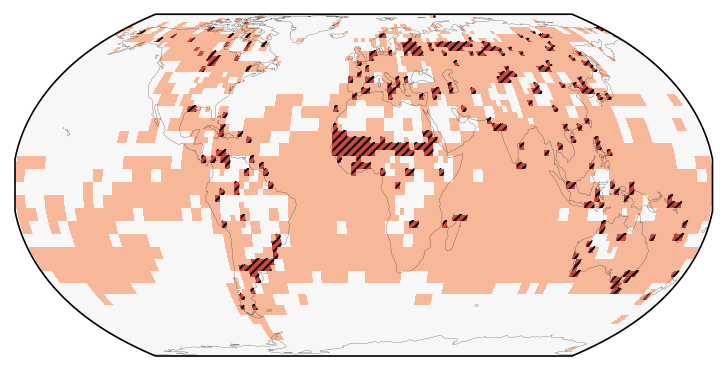

In [112]:
fig = plt.figure(dpi=150)

ax = plt.subplot(projection=ccrs.EqualEarth())

ax.coastlines(lw=0.1)

df.loc[df['LON']>180,"LON"]-=360

n = np.array(df.n_da_impacts).reshape(len(df.LAT.unique()),len(df.LON.unique()))
mesh = ax.pcolormesh(
    df.LON.unique(),
    df.LAT.unique(),
    n,
    cmap=plt.cm.get_cmap('RdBu_r',7), vmin=-3, vmax=3,
    transform=ccrs.PlateCarree(),
    #shading="gouraud"
)
zm = np.ma.masked_less(n, 2)

ax.pcolor(
    df.LON.unique(),
    df.LAT.unique(),
    zm,
    hatch="//////",
    #hatch="......",
    transform=ccrs.PlateCarree(),
    alpha=0.
)

In [87]:
zm

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=999999)

In [114]:
df.loc[
    (df['precip_da_cat']>1) &
    (df['temp_da_cat']>1),
    "study_addition"
] = "add" 

df.loc[
    (df['precip_da_cat']<=1) &
    (df['temp_da_cat']<=1),
    "study_addition"
] = "add" 

df.loc[
    (df['precip_da_cat']>1) &
    (df['temp_da_cat']<=1),
    "study_addition" 
] = "precip" 

df.loc[
    (df['precip_da_cat']<=1) &
    (df['temp_da_cat']>1),
    "study_addition"  
] = "temp"

df.loc[df['study_addition']=="temp","total_study_prop"] = df.loc[df['study_addition']=="temp","temp_study_prop"]
df.loc[df['study_addition']=="precip","total_study_prop"] = df.loc[df['study_addition']=="precip","temp_study_prop"]
df.loc[df['study_addition']=="add","total_study_prop"] = df.loc[df['study_addition']=="add",["precip_study_prop","temp_study_prop"]].sum(axis=1)

df.head()

,LAT,LON,precip_da_cat,precip_study_prop,temp_da_cat,temp_study_prop,temp_da_binary,precip_da_binary,n_da_impacts,max_da_cat,study_addition,total_study_prop
0,-88.75,-178.75,0.0,0.0,0.0,0.0,0,0,0,0.0,add,0.0
1,-88.75,-176.25,0.0,0.0,0.0,0.0,0,0,0,0.0,add,0.0
2,-88.75,-173.75,0.0,0.0,0.0,0.0,0,0,0,0.0,add,0.0
3,-88.75,-171.25,0.0,0.0,0.0,0.0,0,0,0,0.0,add,0.0
4,-88.75,-168.75,0.0,0.0,0.0,0.0,0,0,0,0.0,add,0.0


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


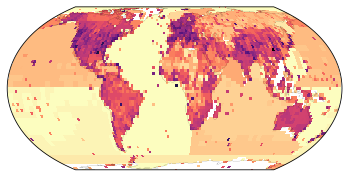

In [115]:
fig = plt.figure()

ax = plt.subplot(projection=ccrs.EqualEarth())

ax.coastlines(lw=0.1)

n = np.array(df.total_study_prop).reshape(len(df.LAT.unique()),len(df.LON.unique()))
#vm = round(n.max()/10*10)
vm = n.max()
n[n==0] = np.nan



mesh = ax.pcolormesh(
    df.LON.unique(),#-degrees*0.5,
    df.LAT.unique(),#-degrees*0.5,
    n,
    norm = mpl.colors.LogNorm(vmin=0.1, vmax=vm),
    #norm = mpl.colors.BoundaryNorm(bounds,256),
    #cmap=plt.cm.get_cmap('YlOrBr',vm/3-1), 
    #cmap = "YlOrBr",
    cmap = "magma_r",
    transform=ccrs.PlateCarree(),
    #alpha=0.5
)

(array([4.646e+03, 1.965e+03, 1.162e+03, 2.720e+02, 1.700e+02, 1.600e+02,
        1.100e+02, 1.670e+02, 1.940e+02, 1.270e+02, 1.270e+02, 1.050e+02,
        1.070e+02, 1.770e+02, 1.160e+02, 1.140e+02, 1.060e+02, 6.200e+01,
        6.900e+01, 7.900e+01, 6.600e+01, 5.000e+01, 3.400e+01, 3.200e+01,
        3.000e+01, 2.700e+01, 1.900e+01, 1.900e+01, 1.200e+01, 8.000e+00,
        7.000e+00, 4.000e+00, 9.000e+00, 4.000e+00, 4.000e+00, 0.000e+00,
        1.000e+00, 3.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([0.        , 0.137847  , 0.275694  , 0.41354101, 0.55138801,
        0.68923501, 0.82708201, 0.96492901, 1.10277601, 1.24062302,
        1.37847002, 1.51631702, 1.65416402, 1.79201102, 1.92985803,
        2.06770503, 2.20555203, 2.34339903, 2.48124603, 2.61909303,
        2.75694004, 2.89478704, 3.03263404, 3.17048104, 3.30832804,
        3.44617504, 3.58402205, 3.72

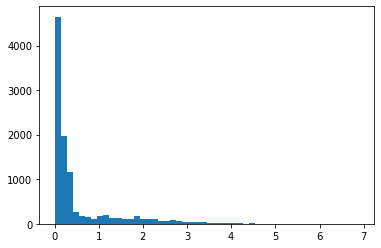

In [116]:
plt.hist(np.log(df.total_study_prop+1),bins=50)

In [148]:
lots = 5
little = 1

df.loc[
    (abs(df['max_da_cat'])>1) & (df['total_study_prop']<little),"evidence_cat"
] = 1

df.loc[
    (abs(df['max_da_cat'])>1) & (df['total_study_prop']>=little),"evidence_cat"
] = 2

df.loc[
    (abs(df['max_da_cat'])>1) & (df['total_study_prop']>=lots),"evidence_cat"
] = 3

df.loc[
    (abs(df['max_da_cat'])<=1) & (df['total_study_prop']<little),"evidence_cat"
] = 4

df.loc[
    (abs(df['max_da_cat'])<=1) & (df['total_study_prop']>=little),"evidence_cat"
] = 5

df.loc[
    (abs(df['max_da_cat'])<=1) & (df['total_study_prop']>=lots),"evidence_cat"
] = 6

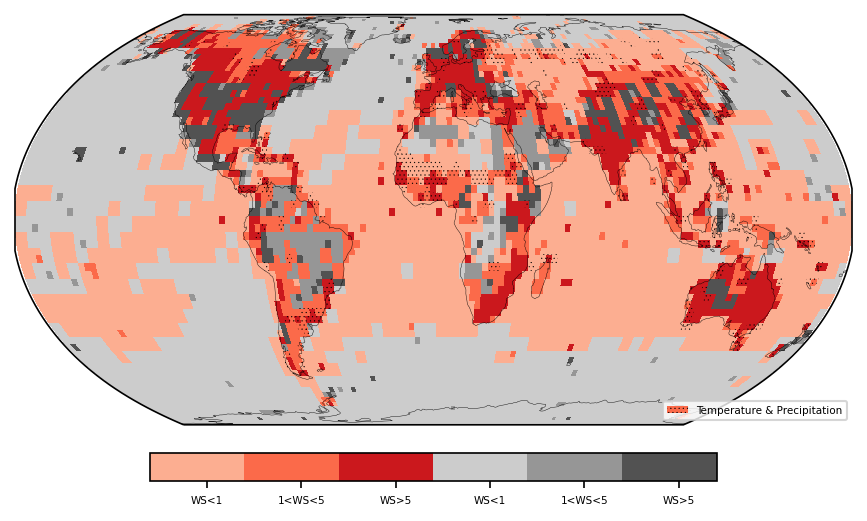

In [268]:
fig = plt.figure(figsize=(7.2, 5), dpi=150)

mpl.rcParams['hatch.linewidth'] = 0.2

ax = plt.subplot(projection=ccrs.EqualEarth())


n = np.array(df.evidence_cat).reshape(len(df.LAT.unique()),len(df.LON.unique()))

ax.coastlines(lw=0.2)

pubugn = ['#ece2f0','#a6bddb','#1c9099']
pubugn = ['#f6eff7','#bdc9e1','#67a9cf','#02818a'][1:]
greens = ['#f7fcb9','#addd8e','#31a354']

greys = ['#f7f7f7','#cccccc','#969696','#525252'][1:]

reds = ['#fee5d9','#fcae91','#fb6a4a','#cb181d'][1:]

colors = reds + greys #pubugn

cmap = mpl.colors.ListedColormap(colors)

mesh = ax.pcolormesh(
    df.LON.unique(),#-degrees*0.5,
    df.LAT.unique(),#-degrees*0.5,
    n,
    cmap = cmap,
    transform=ccrs.PlateCarree(),
)

cbar = plt.colorbar(mesh, orientation="horizontal", pad=0.05, fraction=0.05)
cbar.set_ticks(np.array(np.linspace(1,cmap.N,cmap.N+1)[:-1]+0.5))

n = np.array(df.n_da_impacts).reshape(len(df.LAT.unique()),len(df.LON.unique()))

zm = np.ma.masked_less(n, 2)

dots = ax.pcolor(
    df.LON.unique(),
    df.LAT.unique(),
    zm,
    #hatch="//////",
    hatch="......",
    transform=ccrs.PlateCarree(),
    alpha=0.
)

cbar.set_ticklabels([
    "D&A trend\n 0 impacts",
    f"D&A trend\n <{lots} impacts",
    f"D&A trend\n >{lots} impacts",
    "no D&A trend\n 0 impacts",
    f"no D&A trend\n <{lots} impacts",
    f"no D&A trend\n >{lots} impacts",
])

cbar.set_ticklabels([
    f"WS<{little}",
    f"{little}<WS<{lots}",
    f"WS>{lots}"
]*2)

rect = Rectangle(
    (0, 0),0,0,
    facecolor=reds[1],
    hatch="......",
    label="Temperature & Precipitation",
)

ax.add_patch(rect)
ax.legend(fontsize=5, loc="lower right")

cbar.ax.tick_params(labelsize=5)



In [152]:
from global_land_mask import globe

df['is_land'] = globe.is_land(df.LAT, df.LON)

df.head()

,LAT,LON,precip_da_cat,precip_study_prop,temp_da_cat,temp_study_prop,temp_da_binary,precip_da_binary,n_da_impacts,max_da_cat,study_addition,total_study_prop,evidence_cat,is_land
0,-88.75,-178.75,0.0,0.0,0.0,0.0,0,0,0,0.0,add,0.0,4.0,True
1,-88.75,-176.25,0.0,0.0,0.0,0.0,0,0,0,0.0,add,0.0,4.0,True
2,-88.75,-173.75,0.0,0.0,0.0,0.0,0,0,0,0.0,add,0.0,4.0,True
3,-88.75,-171.25,0.0,0.0,0.0,0.0,0,0,0,0.0,add,0.0,4.0,True
4,-88.75,-168.75,0.0,0.0,0.0,0.0,0,0,0,0.0,add,0.0,4.0,True


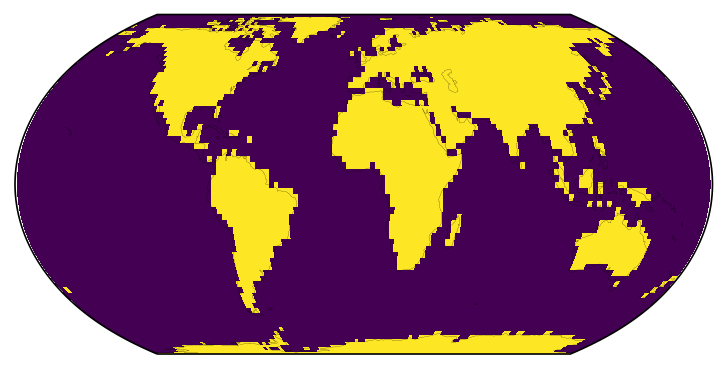

In [154]:
fig = plt.figure(dpi=150)

ax = plt.subplot(projection=ccrs.EqualEarth())

ax.coastlines(lw=0.1)

df.loc[df['LON']>180,"LON"]-=360

n = np.array(df.is_land).reshape(len(df.LAT.unique()),len(df.LON.unique()))
mesh = ax.pcolormesh(
    df.LON.unique(),
    df.LAT.unique(),
    n,
    #cmap=plt.cm.get_cmap('RdBu_r',7), vmin=-3, vmax=3,
    transform=ccrs.PlateCarree(),
    #shading="gouraud"
)




In [160]:
import math
math.radians(180)

3.141592653589793

In [179]:
def area_cell(lat, lon, degrees):
    if lon <0:
        lon+=360
    R = 6371
    f0 = lat-degrees*0.5
    f1 = lat+degrees*0.5
    l0 = math.radians(lon-degrees*0.5)
    l1 = math.radians(lon+degrees*0.5)
    
    print(f0, f1, l0, l1)
    
    print(math.sin(f1)-math.sin(f0))
    
    return (math.sin(f1)-math.sin(f0)) * (l1 - l0) * (R^2)

area_cell(15,15,1)

14.5 15.5 0.2530727415391778 0.27052603405912107
-0.7284275735868864


-80.97202369182479

In [222]:
def area_cell(lat, lon, degrees): 
    # calculate the area of a gridcell given the center lat and lon and the size in degrees
    if lon <0:
        lon+=360
    R = 6371
    f0 = math.radians(lat-degrees*0.5)
    f1 = math.radians(lat+degrees*0.5)
    l0 = math.radians(lon-degrees*0.5)
    l1 = math.radians(lon+degrees*0.5)

    return (math.sin(f1)-math.sin(f0)) * (l1 - l0) * R**2

area_cell(89.5,-90,1)

107.89623558970708

In [225]:
df['area'] = df.apply(lambda x: area_cell(x['LAT'], x['LON'], 2.5), axis=1)
df.head()

,LAT,LON,precip_da_cat,precip_study_prop,temp_da_cat,temp_study_prop,temp_da_binary,precip_da_binary,n_da_impacts,max_da_cat,study_addition,total_study_prop,evidence_cat,is_land,area
0,-88.75,-178.75,0.0,0.0,0.0,0.0,0,0,0,0.0,add,0.0,4.0,True,1685.654015
1,-88.75,-176.25,0.0,0.0,0.0,0.0,0,0,0,0.0,add,0.0,4.0,True,1685.654015
2,-88.75,-173.75,0.0,0.0,0.0,0.0,0,0,0,0.0,add,0.0,4.0,True,1685.654015
3,-88.75,-171.25,0.0,0.0,0.0,0.0,0,0,0,0.0,add,0.0,4.0,True,1685.654015
4,-88.75,-168.75,0.0,0.0,0.0,0.0,0,0,0,0.0,add,0.0,4.0,True,1685.654015


In [256]:
area_sums = df[df['is_land']==True].groupby(['evidence_cat','n_da_impacts'])['area'].sum().reset_index()
area_sums['prop'] = area_sums['area']/area_sums['area'].sum()
area_sums

,evidence_cat,n_da_impacts,area,prop
0,1.0,1,1.916315e+07,0.130219
1,1.0,2,3.685569e+06,0.025044
2,2.0,1,2.746804e+07,0.186653
3,2.0,2,3.935982e+06,0.026746
4,3.0,1,3.132871e+07,0.212887
5,3.0,2,6.497702e+06,0.044154
6,4.0,0,2.265052e+07,0.153916
7,5.0,0,1.487339e+07,0.101069
8,6.0,0,1.755815e+07,0.119312


In [267]:
area_sums[area_sums['evidence_cat'].isin([2,3])].prop.sum()

0.47043939089672515

{0: 0.1302187617893872, 1: 0.0}
{0: 0.15526318865673436, 1: 0.0}
{0: 0.34191588641112025, 1: 0.0}
{0: 0.3686619399369871, 1: 0.0}
{0: 0.5815489526923545, 1: 0.0}
{0: 0.6257025795534595, 1: 0.0}
{0: 0.6257025795534595, 1: 0.15391638837668076}
{0: 0.6257025795534595, 1: 0.254985060793575}
{0: 0.6257025795534595, 1: 0.3742974204465407}


Text(0, 0.5, 'Proportion of land area')

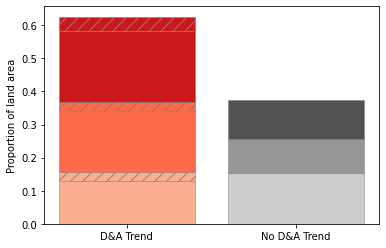

In [269]:
fig, ax = plt.subplots()
bottoms = {0: 0.0, 1: 0.0}

hatch_types = ["","","//"]

mpl.rcParams['hatch.linewidth'] = 1

for i, (name, group) in enumerate(area_sums.groupby('evidence_cat')):
    x = name//4

    for j, group in group.groupby('n_da_impacts'):
        y = group['prop'].values[0]
        ax.bar(
            x,y, bottom=bottoms[x], 
            color=colors[i], hatch=hatch_types[j],
            edgecolor="grey",
            linewidth=0.5
        )
        bottoms[x]+=y
        print(bottoms)
    
ax.set_xticks([0,1])
ax.set_xticklabels(["D&A Trend", "No D&A Trend"])

ax.set_ylabel("Proportion of land area")
    


Text(0.77, 0, 'no D&A\ntrend')

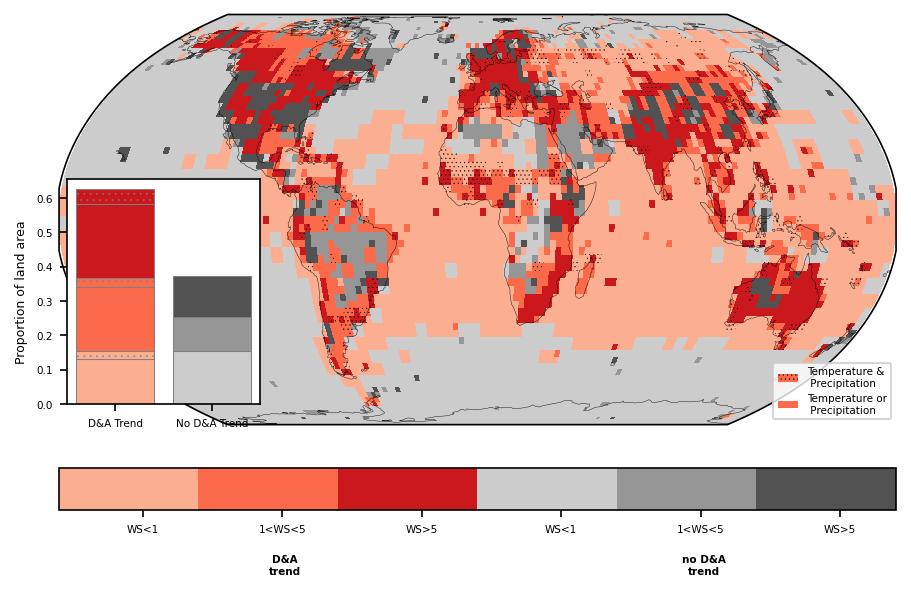

In [305]:
fig = plt.figure(figsize=(7.2, 5), dpi=150)

mpl.rcParams['hatch.linewidth'] = 0.2

gs = gridspec.GridSpec(2, 1, height_ratios=[1, 0.2], hspace=0.08)

ax = plt.subplot(gs[0, 0], projection=ccrs.EqualEarth())
cax = plt.subplot(gs[1, 0])


n = np.array(df.evidence_cat).reshape(len(df.LAT.unique()),len(df.LON.unique()))

ax.coastlines(lw=0.2)

pubugn = ['#ece2f0','#a6bddb','#1c9099']
pubugn = ['#f6eff7','#bdc9e1','#67a9cf','#02818a'][1:]
greens = ['#f7fcb9','#addd8e','#31a354']

greys = ['#f7f7f7','#cccccc','#969696','#525252'][1:]

reds = ['#fee5d9','#fcae91','#fb6a4a','#cb181d'][1:]

colors = reds + greys #pubugn

cmap = mpl.colors.ListedColormap(colors)

mesh = ax.pcolormesh(
    df.LON.unique(),#-degrees*0.5,
    df.LAT.unique(),#-degrees*0.5,
    n,
    cmap = cmap,
    transform=ccrs.PlateCarree(),
)

cbar = plt.colorbar(mesh, orientation="horizontal", pad=-0.95, fraction=1,ax=cax)
cbar.set_ticks(np.array(np.linspace(1,cmap.N,cmap.N+1)[:-1]+0.5))

cax.axis('off')

n = np.array(df.n_da_impacts).reshape(len(df.LAT.unique()),len(df.LON.unique()))

zm = np.ma.masked_less(n, 2)

dots = ax.pcolor(
    df.LON.unique(),
    df.LAT.unique(),
    zm,
    #hatch="//////",
    hatch="......",
    transform=ccrs.PlateCarree(),
    alpha=0.
)

cbar.set_ticklabels([
    "D&A trend\n 0 impacts",
    f"D&A trend\n <{lots} impacts",
    f"D&A trend\n >{lots} impacts",
    "no D&A trend\n 0 impacts",
    f"no D&A trend\n <{lots} impacts",
    f"no D&A trend\n >{lots} impacts",
])

cbar.set_ticklabels([
    f"WS<{little}",
    f"{little}<WS<{lots}",
    f"WS>{lots}"
]*2)

rect = Rectangle(
    (0, 0),0,0,
    facecolor=reds[1],
    hatch="......",
    label="Temperature &\n Precipitation",
)

ax.add_patch(rect)

rect = Rectangle(
    (0, 0),0,0,
    facecolor=reds[1],
    label="Temperature or\n Precipitation",
)

ax.add_patch(rect)
ax.legend(fontsize=5, loc="lower right")

cbar.ax.tick_params(labelsize=5)

###
axins = ax.inset_axes([0.01,0.05,0.23,0.55])
bottoms = {0: 0.0, 1: 0.0}

hatch_types = ["","","...."]

#mpl.rcParams['hatch.linewidth'] = 1

for i, (name, group) in enumerate(area_sums.groupby('evidence_cat')):
    x = name//4
    for j, group in group.groupby('n_da_impacts'):
        y = group['prop'].values[0]
        axins.bar(
            x,y, bottom=bottoms[x], 
            color=colors[i], hatch=hatch_types[j],
            edgecolor="grey",
            linewidth=0.5
        )
        bottoms[x]+=y
    
axins.set_xticks([0,1])
axins.set_xticklabels(["D&A Trend", "No D&A Trend"], fontsize=5)

axins.tick_params(axis="y",labelsize=5)

axins.set_ylabel("Proportion of land area",fontsize=6)

cax.text(0.27,0, "D&A\ntrend", fontsize=5,ha="center", va="top", fontweight="bold")        
cax.text(0.77,0, "no D&A\ntrend", fontsize=5,ha="center", va="top", fontweight="bold")
#ax.text(1.6,0.8, "no D&A\ndata", fontsize=5,ha="left", va="center", fontweight="bold")
